# Simple MA Crossover Backtesting

## Part -1 - Installing Python and Other Prerequisites

I recommend installing the [Anaconda distribution](https://www.anaconda.com/download/) 
to manage Python packages effectively.

To install the required libraries:
> `conda install numpy pandas matplotlib jupyter`

To install the IDE that I'm using (JupyterLab):
> `conda install jupyterlab`

## Part 0 - Loading Libraries

First, we import the required libraries.

- `pandas` & `numpy` - Excel on crack. Usually use for data science and analytics.
- `matplotlib` - The go-to basic graphing library

In [1]:
# Load Libraries

import pandas as pd, numpy as np
import matplotlib.pyplot as plt
%matplotlib widget

## Part 1 - Coding out the Strategy

### Loading Data

First, we load the data into a 'table' (`Dataframe`). 

In [2]:
# Load Data

OHLCV = pd.read_csv("EURUSD_M1_20181006-20181013.csv", index_col='time')
OHLCV.index = pd.to_datetime(OHLCV.index)

### Checking Data

We can check what the data is like by printing its `head` or `tail`.

- `head` - Prints the 1st 5 data points (default)
- `tail` - Prints the last 5 data points (default)

In [3]:
OHLCV.tail()

open     high      low    close  volume
time                                                           
2018-10-12 18:06:00  1.15576  1.15592  1.15575  1.15588      42
2018-10-12 18:07:00  1.15588  1.15592  1.15586  1.15588      29
2018-10-12 18:08:00  1.15589  1.15594  1.15586  1.15594      40
2018-10-12 18:09:00  1.15594  1.15607  1.15594  1.15602      16
2018-10-12 18:10:00  1.15597  1.15602  1.15588  1.15594      67

We can also check what the size of the data as well.

`shape` gets the number of rows and columns.

In [4]:
OHLCV.shape

(6806, 5)

### Strategy

Let's recap how the strategy is executed.

- OHLCV: 
  + EURUSD
- Parameters:
  + fastMA = **20**
  + slowMA = **50**
- Indicators:
  + MACross = SMA(fastMA) - SMA(slowMA)
- Conditions:
  + Buy:
    * Open:
      - MACross.shift(1) > 0 && MACross.shift(2) < 0
    * Close:
      - MACross.shift(1) < 0 && MACross.shift(2) > 0
  + Sell:
    * Open:
      - MACross.shift(1) < 0 && MACross.shift(2) > 0
    * Close:
      - MACross.shift(1) > 0 && MACross.shift(2) < 0

### Defining Parameters and Indicators

In [5]:
# Parameters

fastMA = 20
slowMA = 50

`rolling` is used to determine the group size of which you'd be manipulating the data.

`rolling(period).mean()` gives the mean of that particular period --> Simple Moving Average

Other methods include `min` and `max` (Donchian channels) and `sum`.

In [6]:
# Moving Average Crossover
def MACross(series, Fast, Slow):
    return series.rolling(Fast).mean() - \
           series.rolling(Slow).mean()

We apply the `MACross` function to the data here.

In [7]:
# Set indicators

OHLCV['MACross'] = MACross(OHLCV.close, fastMA, slowMA)

In [8]:
OHLCV.tail()

open     high      low    close  volume   MACross
time                                                                     
2018-10-12 18:06:00  1.15576  1.15592  1.15575  1.15588      42  0.000165
2018-10-12 18:07:00  1.15588  1.15592  1.15586  1.15588      29  0.000164
2018-10-12 18:08:00  1.15589  1.15594  1.15586  1.15594      40  0.000152
2018-10-12 18:09:00  1.15594  1.15607  1.15594  1.15602      16  0.000142
2018-10-12 18:10:00  1.15597  1.15602  1.15588  1.15594      67  0.000129

### Generating Signals

In this section, we'll create a new `DataFrame` for the signal generation.

In [9]:
# Set up signals

# Creates a new dataframe, sets the index to follow OHLCV
signal = pd.DataFrame(index=OHLCV.index)

Here, we'll be generating the Buy signals for opening and closing positions.  

This is done by checking the conditions for each candle, and if the candle meets the
conditions we've set, it sets the opening price to another column, otherwise, it sets `NaN`
to that column.

The `fillna` method on the `BuyClose` column is to backfill (`bfill`) the price of which 
the trade is to be closed at. Why we do this is so that the opening and closing prices 
align in the same row.  
The second `fillna` method is to fill up any `NaN` values that is at the tail, denoting 
that the backtest has stopped halfway through its trade.

In [10]:
# np.where == IF in Excel
signal['BuyOpen'] = np.where((OHLCV.MACross.shift(1) > 0) & (OHLCV.MACross.shift(2) < 0), OHLCV.open, np.nan)
signal['BuyClose'] = np.where((OHLCV.MACross.shift(1) < 0) & (OHLCV.MACross.shift(2) > 0), OHLCV.open, np.nan)
signal.BuyClose.fillna(method='bfill', inplace = True)
signal.BuyClose.fillna(value=OHLCV.close[-1], inplace = True)

In [11]:
signal['SellOpen'] = np.where((OHLCV.MACross.shift(1) < 0) & (OHLCV.MACross.shift(2) > 0), OHLCV.open, np.nan)
signal['SellClose'] = np.where((OHLCV.MACross.shift(1) > 0) & (OHLCV.MACross.shift(2) < 0), OHLCV.open, np.nan)
signal.SellClose.fillna(method='bfill', inplace = True)
signal.SellClose.fillna(value=OHLCV.close[-1], inplace = True)

We do a `dropna` here as well to remove any redundant data points where there are no
`BuyOpen` and `SellOpen` signals (`how` denotes whether it is an AND `(all`) or OR 
(`any`) expression).

In [12]:
signal.dropna(inplace = True, subset=['SellOpen', 'BuyOpen'], how='all')

Here, we just set the units to be fixed at 1000 units (0.01 lots) to make 
it simple.

In [13]:
signal['BuyUnits'] = 1000
signal['SellUnits'] = -1000

We can see what the data looks like here.

In [14]:
signal.head()

BuyOpen  BuyClose  SellOpen  SellClose  BuyUnits  \
time                                                                    
2018-10-07 22:12:00      NaN   1.15248   1.15248    1.15253      1000   
2018-10-07 22:30:00  1.15253   1.15243       NaN    1.15253      1000   
2018-10-07 23:12:00      NaN   1.15243   1.15243    1.15250      1000   
2018-10-08 00:06:00  1.15250   1.15208       NaN    1.15250      1000   
2018-10-08 00:43:00      NaN   1.15208   1.15208    1.15202      1000   

                     SellUnits  
time                            
2018-10-07 22:12:00      -1000  
2018-10-07 22:30:00      -1000  
2018-10-07 23:12:00      -1000  
2018-10-08 00:06:00      -1000  
2018-10-08 00:43:00      -1000

### Generating Profit and Equity Curve

We generate the `Profit` column by checking whether there is a value in `BuyOpen`
or `SellOpen`, and calculate the profit accordingly.

`0.00014` simulates the spread incurred for each trade.

In [15]:
signal['Profit'] = np.where(np.isnan(signal.BuyOpen) == False, 
                            (signal.BuyClose - signal.BuyOpen - 0.00014) * signal.BuyUnits,
                            np.where(np.isnan(signal.SellOpen) == False, 
                                     (signal.SellClose - signal.SellOpen - 0.00014) * signal.SellUnits,
                                     0))

We generate the `Equity` curve by calling the `cumsum` (cumulative sum) method.

In [16]:
signal['Equity'] = signal.Profit.cumsum()

Plotting using `matplotlib` gives you this equity curve.

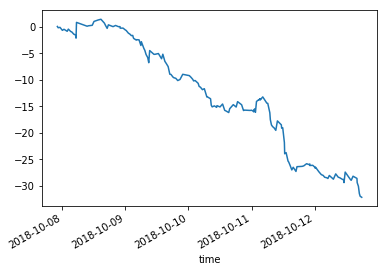

In [17]:
plt.figure()
signal['Equity'].plot()
plt.show()

## Part 2 - Optimisation

### Process Encapsulation

We encapsulate the above steps into one function so that it can be reused.

In [18]:
def generateEquity(ohlcvFile, MA1=20, MA2=50, units=1000, spread=0.00014):
    OHLCV = pd.read_csv(ohlcvFile, index_col='time')
    OHLCV.index = pd.to_datetime(OHLCV.index)
    OHLCV['MACross'] = MACross(OHLCV.close, MA1, MA2)
    signal = pd.DataFrame(index=OHLCV.index)
    signal['BuyOpen'] = np.where((OHLCV.MACross.shift(1) > 0) & (OHLCV.MACross.shift(2) < 0), OHLCV.open, np.nan)
    signal['BuyClose'] = np.where((OHLCV.MACross.shift(1) < 0) & (OHLCV.MACross.shift(2) > 0), OHLCV.open, np.nan)
    signal.BuyClose.fillna(method='bfill', inplace = True)
    signal.BuyClose.fillna(value=OHLCV.close[-1], inplace = True)
    signal['SellOpen'] = np.where((OHLCV.MACross.shift(1) < 0) & (OHLCV.MACross.shift(2) > 0), OHLCV.open, np.nan)
    signal['SellClose'] = np.where((OHLCV.MACross.shift(1) > 0) & (OHLCV.MACross.shift(2) < 0), OHLCV.open, np.nan)
    signal.SellClose.fillna(method='bfill', inplace = True)
    signal.SellClose.fillna(value=OHLCV.close[-1], inplace = True)
    signal['BuyUnits'] = units
    signal['SellUnits'] = -units
    signal['Profit'] = np.where(np.isnan(signal.BuyOpen) == False, 
                                (signal.BuyClose - signal.BuyOpen - 0.00014) * signal.BuyUnits,
                                np.where(np.isnan(signal.SellOpen) == False, 
                                         (signal.SellClose - signal.SellOpen - 0.00014) * signal.SellUnits,
                                         0))
    signal['Equity'] = signal.Profit.cumsum()
    return signal.Equity

This time, we'll use another csv file (2 years as compared to 1 weeks' worth).

In [19]:
twoYearsEquity = generateEquity('EURUSDM1_20161016-20181012.csv', 20, 50)

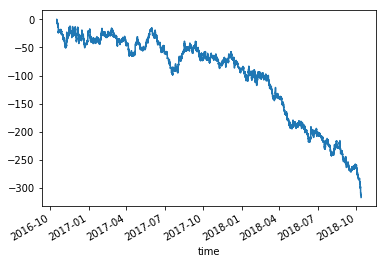

In [20]:
plt.figure()
twoYearsEquity.plot()
plt.show()

Notice that we change `fastMA` and `slowMA` parameters to `MA1` and `MA2` - we do not have 
to enforce that `MA1` < `MA2` as both instances are valid.

In [21]:
twoYearsEquity = generateEquity('EURUSDM1_20161016-20181012.csv', 50, 20)

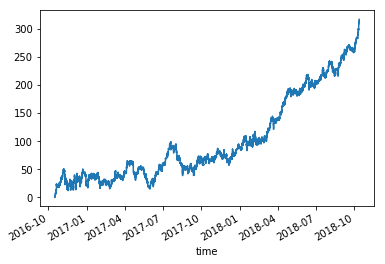

In [22]:
plt.figure()
twoYearsEquity.plot()
plt.show()

### Simulation with Parameter Ranges

Now that we've encapsulate the function, we can now run it multiple times with 
different parameters.

In [23]:
fastMARange = range(10, 101, 10)
slowMARange = range(10, 101, 10)

In [24]:
results = pd.DataFrame()
for i in fastMARange:
    for j in slowMARange:
        if i != j:
            print('\rLoading {}, {}'.format(i, j), end='')
            results['{}, {}'.format(i, j)] = (generateEquity('EURUSDM1_20161016-20181012.csv', MA1=i, MA2=j))
results.fillna(method='ffill', inplace = True)
print('\rDone.')

Done.


In [25]:
results.shape

(712322, 90)

<Figure size 432x288 with 0 Axes>

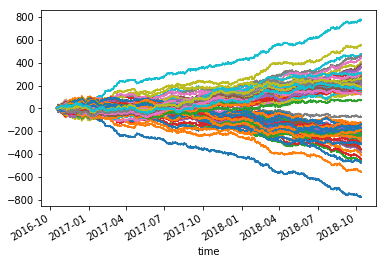

In [26]:
plt.figure()
results.plot(legend=None)
plt.show()

In [27]:
# Filters columns that give positive returns
results = results[results.columns[results.iloc[-1,:] > 0]]

<Figure size 432x288 with 0 Axes>

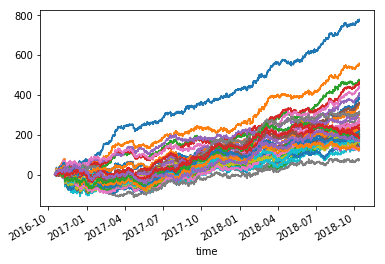

In [28]:
plt.figure()
results.plot(legend=None)
plt.show()

In [29]:
results.shape

(712322, 45)

In [30]:
def Drawdown(strategy):
    df = pd.DataFrame(strategy)
    df['Peak'] = strategy.cummax()
    df['diff'] = df.Peak - strategy
    return df['diff'].cummax()

In [31]:
resultsDD = results.apply(lambda x: Drawdown(x))

<Figure size 432x288 with 0 Axes>

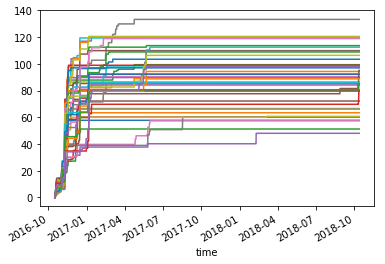

In [32]:
plt.figure()
resultsDD.plot(legend=None)
plt.show()

In [33]:
# Filters columns that has only less than 90 for drawdown from the last timestamp
results = results[results.columns[resultsDD.iloc[-1,:] < 90]]
resultsDD = resultsDD[resultsDD.columns[resultsDD.iloc[-1,:] < 90]]

In [34]:
results.shape

(712322, 23)

<Figure size 432x288 with 0 Axes>

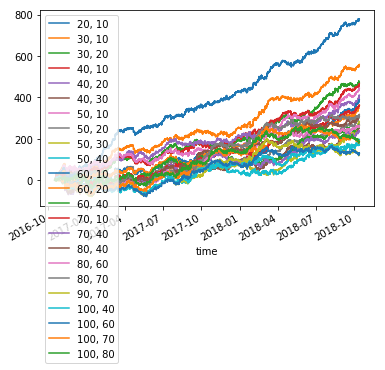

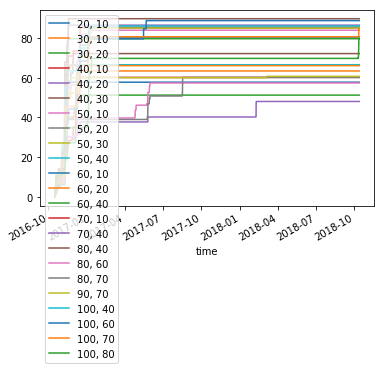

In [35]:
plt.figure()
results.plot()
resultsDD.plot()
plt.show()

In [36]:
report = [results.iloc[-1].copy(), resultsDD.iloc[-1].copy()]
report[0].name, report[1].name = 'Equity', 'Drawdown'
report = pd.DataFrame(report).T

In [37]:
report['MA1'] = report.index
report['MA1'] = report.MA1.apply(lambda x: x.split(', ')[0])
report['MA2'] = report.index
report['MA2'] = report.MA2.apply(lambda x: x.split(', ')[1])
report['EDR'] = report.Equity / report.Drawdown

In [38]:
report

Equity  Drawdown  MA1 MA2        EDR
20, 10   779.01     57.72   20  10  13.496362
30, 10   558.70     63.38   30  10   8.815084
30, 20   474.50     51.21   30  20   9.265768
40, 10   464.75     60.14   40  10   7.727802
40, 20   411.16     48.00   40  20   8.565833
40, 30   266.88     72.14   40  30   3.699473
50, 10   445.59     57.32   50  10   7.773726
50, 20   317.18     60.11   50  20   5.276659
50, 30   282.08     60.66   50  30   4.650181
50, 40   191.68     66.52   50  40   2.881539
60, 10   386.84     80.45   60  10   4.808452
60, 20   362.32     66.05   60  20   5.485541
60, 40   266.87     79.62   60  40   3.351796
70, 10   360.53     85.27   70  10   4.228099
70, 40   235.78     86.46   70  40   2.727041
80, 40   307.03     89.71   80  40   3.422472
80, 60   264.01     83.90   80  60   3.146722
80, 70   311.12     85.32   80  70   3.646507
90, 70   128.90     84.93   90  70   1.517720
100, 40  172.21     86.04  100  40   2.001511
100, 60  130.24     88.74  100  60   1.467658
100, 70  187.01     84.53  100  70   2.212351
100, 80  184.37     79.65  100  80   2.314752

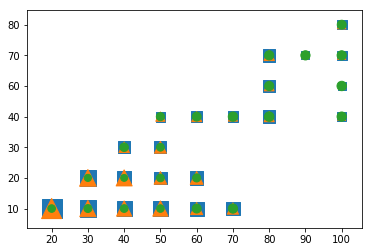

In [39]:
plt.scatter(x=report.MA1, y=report.MA2, s=report.Equity*.5, marker='s')
plt.scatter(x=report.MA1, y=report.MA2, s=report.EDR*30, marker='^')
plt.scatter(x=report.MA1, y=report.MA2, s=report.Drawdown)
plt.show()

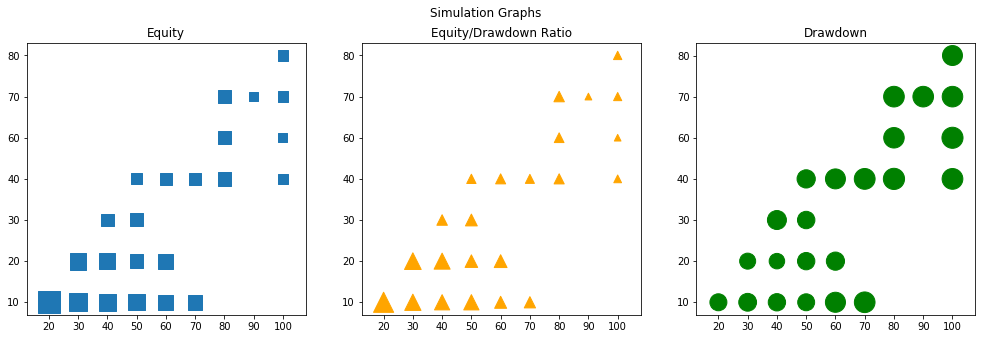

In [40]:
fig, axs = plt.subplots(nrows=1, ncols=3, sharex=True, figsize=(17,5))

axs[0].scatter(x=report.MA1, y=report.MA2, s=report.Equity*0.6, marker='s')
axs[0].set_title('Equity')
axs[1].scatter(x=report.MA1, y=report.MA2, s=report.EDR*30, marker='^', c='orange')
axs[1].set_title('Equity/Drawdown Ratio')
axs[2].scatter(x=report.MA1, y=report.MA2, s=report.Drawdown*5, c='green')
axs[2].set_title('Drawdown')

fig.suptitle('Simulation Graphs')

plt.show()

## Not Covered

- Checking the distribution of profits
- In/out sampling